In [3]:
import numpy as np
import xarray as xr
import dask.array as da 
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from ad99 import AlexanderDunkerton1999
from constants import GRAV,R_DRY,C_P

In [4]:
ds = xr.open_dataset('data/atmos_4xdaily_flag0.nc',chunks={'time':1})
ds_mask_trop = xr.open_dataset('data/loon_masks.nc')
ds_mask_trop['lon'] = (ds_mask_trop.lon + 360) % 360 
ds_mask_trop = ds_mask_trop.sortby('lon')
interp_mask = ds_mask_trop.interp(lat=ds.lat,lon=ds.lon,method='nearest').astype(bool)
total_mask = sum(interp_mask[d] for d in interp_mask.data_vars)
ocean_expac = ds.where(total_mask).stack(points = ['lat','lon'])
ocean_expac = ocean_expac.dropna('points',how='all')
ocean_expac = ocean_expac.isel(pfull=slice(None,None,-1))

ocean_expac = ocean_expac[['ucomp','temp','vcomp','height','gwfu_cgwd','gwfv_cgwd']]
ocean_expac = ocean_expac.transpose('time','points','pfull')



In [5]:
dTdz = da.gradient(ocean_expac.temp,axis=-1)/da.gradient(ocean_expac.height,axis=-1)
Ns2 = GRAV/ocean_expac.temp*(dTdz + GRAV/C_P) 
bflim =  5e-3
Ns2 = xr.where(Ns2 < bflim**2,bflim**2,Ns2)
Ns = da.sqrt(Ns2)
rho = (100*ocean_expac.pfull.data[None,None,:])/(R_DRY*ocean_expac.temp)

rho = rho.data.persist()
lat = ocean_expac.lat.data
u = ocean_expac.ucomp.data.persist()
z = ocean_expac.height.data.persist()
Ns = Ns.data.persist()

In [6]:
lat = da.broadcast_to(lat,(u.shape[0],u.shape[1])).persist()

### vectorized dask attempt

In [6]:
source_level_height = 9000
dc = 1.2
source_levels = da.argmin(da.abs(z - source_level_height*da.cos(da.deg2rad(lat))[...,None] ),axis=-1,keepdims=True)

def take_along_axis(data,idx):
    return np.take_along_axis(data[0],idx[0],axis=-1).squeeze(axis=-1)

rho_0 = da.blockwise(take_along_axis,"ij",rho,"ijk",source_levels,"ijk",dtype=rho.dtype)
u_0 = da.blockwise(take_along_axis,"ij",u,"ijk",source_levels,"ijk",dtype=u.dtype)
c0 = np.arange(-99.6,99.6+dc,dc,dtype=np.float32)

In [7]:
Bm = 0.4
cw = 35
CUT_OFF = 10.0

def source_spectrum( c, u=None,lat=None):
    u = u[...,None]
    if lat is None:
        c0 = u 
    else:
        c0 =da.where(lat[...,None] >= CUT_OFF,0.0,u)
    return np.sign(c-u)*Bm*np.exp(-np.log(2,dtype=u.dtype) * ((c-c0) /cw) ** 2)

spectrum = source_spectrum(c0,u_0)

In [ ]:
dz = z[..., 1:] - z[..., :-1]
H = -(dz / da.log(rho[..., 1:] / rho[..., :-1]))
dz = da.concatenate([dz[..., 0, None], dz], axis=-1)
H = da.concatenate([H[..., 0, None], H], axis=-1)
dz = dz.rechunk(z.chunks)   
H = H.rechunk(z.chunks)

In [ ]:
kwv = (2*np.pi)/(300e3)
def reflection_frequency(N,H):
    alpha = 1/(2*H)
    return np.sqrt( N**2 * kwv**2/ (kwv**2 + alpha*alpha))

f = reflection_frequency(Ns,H)


In [ ]:
intrinsic_freq = kwv*(c0[:,None] - u[...,None,:])

In [ ]:
np.abs(intrinsic_freq)[0,0].compute()

array([[0.00203461, 0.00204911, 0.00208376, ..., 0.00149434, 0.00142883,
        0.0012988 ],
       [0.00200948, 0.00202398, 0.00205862, ..., 0.00146921, 0.0014037 ,
        0.00127366],
       [0.00198434, 0.00199885, 0.00203349, ..., 0.00144408, 0.00137857,
        0.00124853],
       ...,
       [0.00208715, 0.00207265, 0.002038  , ..., 0.00262742, 0.00269293,
        0.00282296],
       [0.00211228, 0.00209778, 0.00206313, ..., 0.00265255, 0.00271806,
        0.0028481 ],
       [0.00213742, 0.00212291, 0.00208827, ..., 0.00267768, 0.00274319,
        0.00287323]], shape=(167, 40), dtype=float32)

In [ ]:
level_idx = da.broadcast_to(da.arange(z.shape[-1],dtype=int),z.shape,chunks=z.chunks)  


In [ ]:
reflection_frequency = reflection_frequency(Ns, H)
intrinsic_freq = kwv * (c0[..., :, None] - u[..., None, :])
tir = (da.abs(intrinsic_freq) >= reflection_frequency[..., None, :]) * (
    (level_idx >= source_levels)[..., None, :]
)

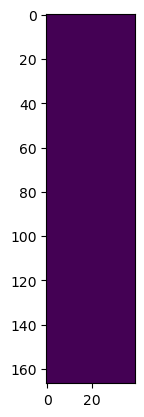

In [ ]:
plt.imshow(tir[0,10].compute())

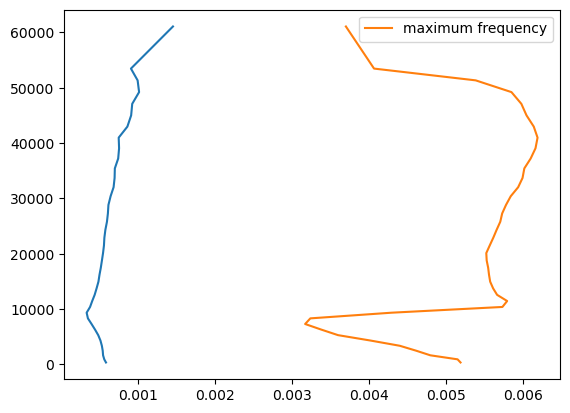

In [ ]:
plt.plot(da.abs(intrinsic_freq[0,10,100].compute()),z[0,0].compute())
plt.plot(f[0,10].compute(),z[0,0].compute(),label='maximum frequency')
plt.legend()

In [ ]:

tir_idx = da.where(
    tir.any(axis=-1, keepdims=True),
    da.argmax(tir, axis=-1, keepdims=True),
    tir.shape[-1]+1,
)

In [ ]:

Fs0 = 4e-3
def intermittency(rho_source, u=None):
    return (Fs0 * dc) / (
        rho_source * da.sum(da.abs(source_spectrum(c0, u))*dc, axis=-1)
    )

eps = intermittency(rho_0,u_0)



In [ ]:
Q0 = (2 * Ns[..., None, :] * spectrum[..., :, None] * rho_0[..., None, None]) / (
rho[..., None, :]
* kwv
* (c0[..., :, None] - u[..., None, :]) ** 3
)  # batch_shape, c,z
signchange = (c0[..., :, None] - u[..., None, :]) * (c0[...,:,None] - u_0[..., None,None]) <= 0
breaking_waves = ((Q0 >= 1) | (signchange)) & (level_idx >= source_levels)[..., None, :]

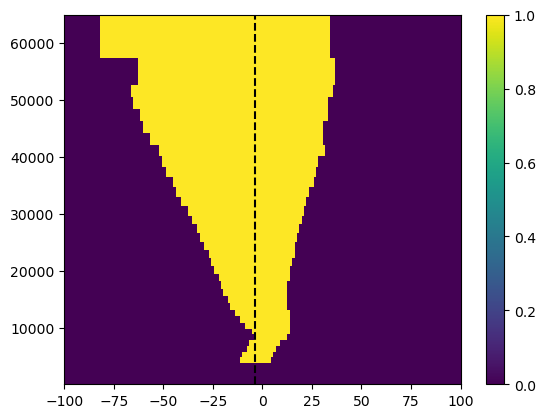

In [ ]:
plt.pcolormesh(*np.meshgrid(c0,z[0,10].compute(),indexing='xy'),breaking_waves[0,10].T.compute(),shading='nearest',vmin=0,vmax=1)
plt.axvline(u_0[0,10].compute(),color='k',linestyle='--')
plt.colorbar()

In [ ]:
u_0[0,0].compute()

np.float32(3.8016508)

In [ ]:
breaking_idx = da.where(
    breaking_waves.any(axis=-1, keepdims=True),
    da.argmax(breaking_waves, axis=-1, keepdims=True),
    breaking_waves.shape[-1],
)
true_breaking_idx = da.where(breaking_idx < tir_idx, breaking_idx, -1)
true_reflecting_idx = da.where(tir_idx <= breaking_idx,tir_idx,-1)

In [ ]:
true_reflecting_idx[0,0].compute()

array([[-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],

In [ ]:
tir_idx 

dask.array<where, shape=(360, 2504, 167, 1), dtype=int64, chunksize=(1, 2504, 167, 1), chunktype=numpy.ndarray>

In [ ]:
breaking = (true_breaking_idx == level_idx[...,None,:]) & (level_idx >source_levels)[...,None,:]
reflecting = (true_reflecting_idx == level_idx[...,None,:])
topwaves = (true_breaking_idx == z.shape[-1])
source_unstable = (true_breaking_idx == source_levels[...,None,:])

In [ ]:
b = breaking[0,0].compute()
r = reflecting[0,0].compute()

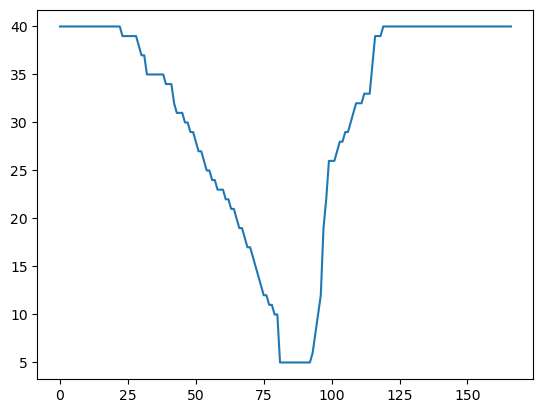

In [ ]:
plt.plot(breaking_idx[0,0].compute())

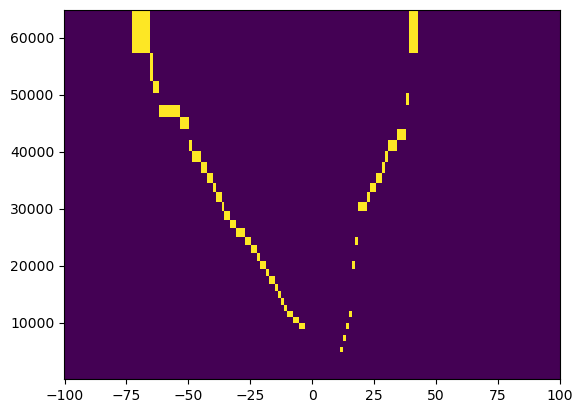

In [ ]:
plt.pcolormesh(*np.meshgrid(c0,z[0,0].compute(),indexing='xy'),b.T,shading='nearest',vmin=0,vmax=1)

In [ ]:
F0 = da.sum(breaking*rho_0[...,None,None] * spectrum[...,None],axis=-2)
rho_half = da.concatenate([rho_0[...,None],np.sqrt(rho[...,1:]*rho[...,:-1])],axis=-1)
half_lvl_drag = F0 * eps[...,None]/ (rho_half * dz)
full_lvl_drag = da.concatenate([0.5*(half_lvl_drag[...,1:] + half_lvl_drag[...,:-1]),0.5*half_lvl_drag[...,-1][...,None]],axis=-1)
full_lvl_drag = full_lvl_drag.rechunk(z.chunks)


In [ ]:
fd = full_lvl_drag.compute()

In [7]:
from ad99dask import AlexanderDunkerton1999Dask
ad99_nvr = AlexanderDunkerton1999Dask(dc=0.4,exclude_unbroken=True,use_intrinsic_c='never')
ad99_alw = AlexanderDunkerton1999Dask(dc=0.4,exclude_unbroken=True,use_intrinsic_c='always')
ad99_dask = AlexanderDunkerton1999Dask(dc=0.4,exclude_unbroken=True,use_intrinsic_c=10.0)


## dask aware! ad99

In [6]:
ad99 = AlexanderDunkerton1999(exclude_unbroken=True)

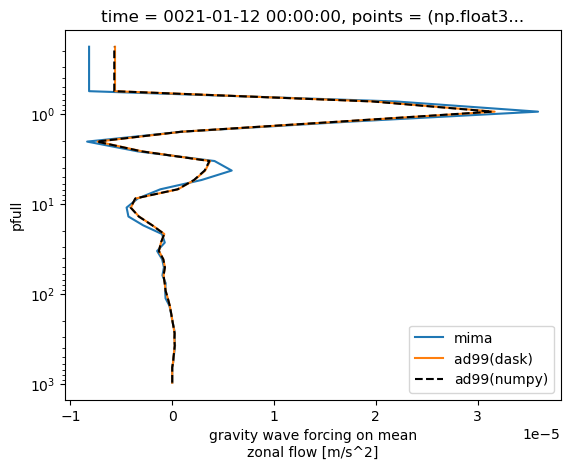

In [ ]:
ax = plt.axes()
point = (10,30)

single_col_gwd = ad99.gwd(u[*(point)],Ns[*(point)],z[*(point)],rho[*(point)],lat=lat[*(point)])
ocean_expac.gwfu_cgwd[*(point)].plot(ax=ax,y='pfull',yincrease=False,yscale='log',label='mima')
ax.plot(fd[*(point)],ocean_expac.pfull.data,label='ad99(dask) ')
ax.plot(single_col_gwd,ocean_expac.pfull.data,linestyle='--',color='k',label='ad99(numpy)')

plt.legend()

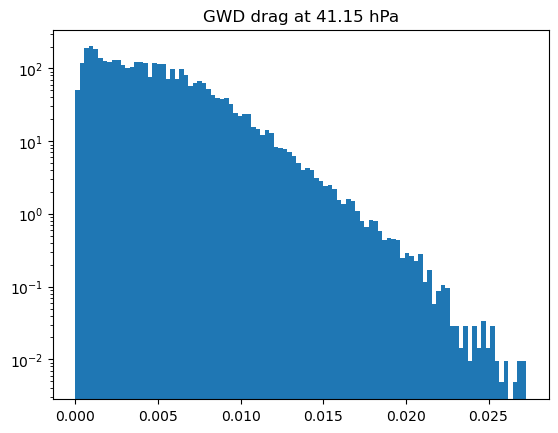

In [ ]:
drag = np.abs(fd[...,20].ravel())*3600
plt.title(f'GWD drag at {ocean_expac.pfull.values[20]:.2f} hPa')
plt.hist(drag[drag>0],bins=100,density=True)
plt.yscale('log')

(array([7.69511127e-05, 7.35310632e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

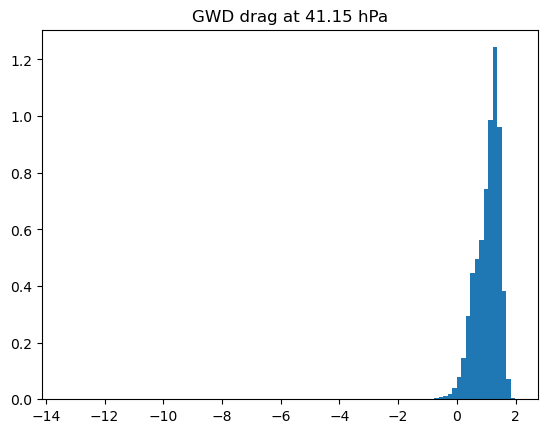

In [ ]:
plt.title(f'GWD drag at {ocean_expac.pfull.values[20]:.2f} hPa')
plt.hist(np.log10(3600*drag[drag>0]),bins=100,density=True)


### momentum flux

In [8]:
import dask
from dask.diagnostics import ProgressBar
fntv,fptv = ad99_dask.momentum_flux_neg_ptv(u,Ns,z,rho,lat=lat)
fntv_nvr,fptv_nvr = ad99_nvr.momentum_flux_neg_ptv(u,Ns,z,rho,lat=lat)
fntv_alw,fptv_alw = ad99_alw.momentum_flux_neg_ptv(u,Ns,z,rho,lat=lat)

fptv,ftnv = dask.persist(fptv,fntv)
fptv_nvr = fptv_nvr.persist()
fptv_alw = fptv_alw.persist()



: 

In [8]:
fnet = fntv + fptv

In [9]:
fnet = fnet.persist()

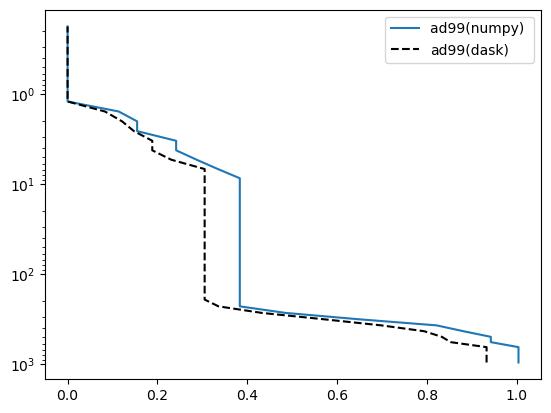

In [10]:
ax = plt.axes()
point = (10,36)

_,ptv_ad99 = ad99.momentum_flux_neg_ptv(u[*(point)],Ns[*(point)],z[*(point)],rho[*(point)],lat=lat[*(point)])
# ocean_expac.gwfu_cgwd[*(point)].plot(ax=ax,y='pfull',yincrease=False,yscale='log',label='mima')
ax.plot(1000*ptv_ad99,ocean_expac.pfull.data,label='ad99(numpy) ')
ax.plot(1000*fptv[*(point)],ocean_expac.pfull.data,linestyle='--',color='k',label='ad99(dask)')
plt.gca().invert_yaxis()
plt.yscale('log')
plt.legend()

In [17]:
level = 100#hPa
i_level = np.argmin(np.abs(ocean_expac.pfull.values - level))

In [18]:

flux_ptv_level = fptv[...,i_level].ravel().compute()
flux_ptv_level = flux_ptv_level[flux_ptv_level > 0]

flux_ptv_level_nvr = fptv_nvr[...,i_level].ravel().compute()
flux_ptv_level_nvr = flux_ptv_level_nvr[flux_ptv_level_nvr > 0]

flux_ptv_level_alw = fptv_alw[...,i_level].ravel().compute()
flux_ptv_level_alw = flux_ptv_level_alw[flux_ptv_level_alw > 0]



In [19]:
flux_ptv_level

array([0.00081966, 0.00077465, 0.0008012 , ..., 0.00060549, 0.00048769,
       0.00039627], shape=(859142,))

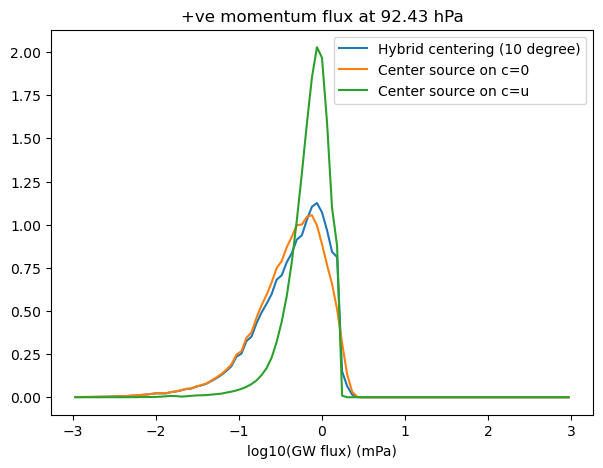

In [21]:
bins = np.linspace(-3,3,100)
plt.figure(figsize=(7,5))
bc = 0.5*(bins[1:] + bins[:-1])
mima_spec,_ = np.histogram(np.log10(flux_ptv_level*1000),bins=bins,density=True)
nevr_spec,_ = np.histogram(np.log10(flux_ptv_level_nvr*1000),bins=bins,density=True)
always_spec,_ = np.histogram(np.log10(flux_ptv_level_alw*1000),bins=bins,density=True)
plt.plot(bc,mima_spec,label='Hybrid centering (10 degree)')
plt.plot(bc,nevr_spec,label='Center source on c=0')
plt.plot(bc,always_spec,label='Center source on c=u')
plt.xlabel('log10(GW flux) (mPa)')
plt.title(f'+ve momentum flux at {ocean_expac.pfull.values[i_level]:.2f} hPa')
plt.legend()

In [22]:
fnet_level = fnet[...,i_level].ravel().compute()
fnet_level = fnet_level[fnet_level > 0]

(array([2.62585937e-03, 4.20137500e-03, 4.12635044e-03, 4.27639955e-03,
        4.72654687e-03, 5.92693973e-03, 7.87757812e-03, 8.47777454e-03,
        8.10265178e-03, 9.07797097e-03, 1.12536830e-02, 1.30542723e-02,
        1.32793460e-02, 1.94313594e-02, 2.10818995e-02, 2.49081518e-02,
        2.78341093e-02, 3.04599687e-02, 3.77373504e-02, 3.70621294e-02,
        4.62901495e-02, 5.28923102e-02, 6.57215089e-02, 7.15734240e-02,
        8.35023280e-02, 9.01795133e-02, 1.08410480e-01, 1.23265341e-01,
        1.41571332e-01, 1.60252446e-01, 1.80359027e-01, 2.12394511e-01,
        2.40303645e-01, 2.71438835e-01, 3.21330163e-01, 3.64019134e-01,
        4.06257957e-01, 4.63051544e-01, 5.18944836e-01, 5.71837147e-01,
        6.59615874e-01, 7.33139937e-01, 8.10940399e-01, 8.67583937e-01,
        9.50636117e-01, 1.01928358e+00, 1.04831809e+00, 1.07960332e+00,
        1.05859645e+00, 1.00120267e+00, 9.08547343e-01, 8.23169401e-01,
        5.07090957e-01, 1.56876341e-01, 6.75971227e-02, 1.830599

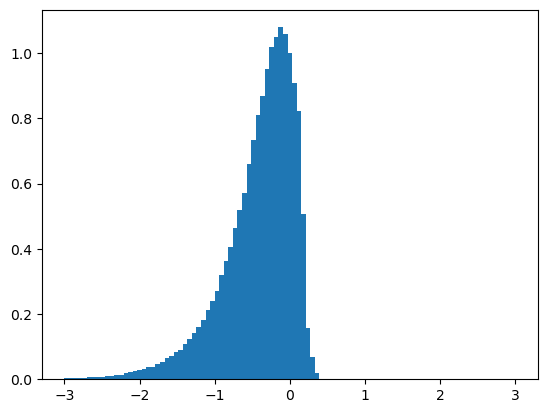

In [23]:
plt.hist(np.log10(fnet_level*1000),bins=bins,density=True)